## HW2 Dropout Probability 20201514 이현수
https://nilanjanchattopadhyay.github.io/basics/2020/04/20/Regularization-from-Scratch-Dropout.html


In [10]:
import numpy as np

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [11]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        # He normal initialization
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        # self.weights = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.zeros((output_size, 1))
        # self.bias = np.random.rand(output_size, 1) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    # computes dL/dW, dL/dB for a given output_error=dL/dY. Returns input_error=dL/dX.
    def backward_propagation(self, output_error, learning_rate):
        weights_error = np.outer(output_error, self.input)  # dL/dW = dL/dY * dY/dW
        input_error = np.dot(self.weights.T, output_error)  # dL/dX = dL/dY * dY/dX
        bias_error = output_error                       # dL/dB = dL/dY * dY/dB

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * bias_error
        return input_error

In [12]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [13]:
class BatchNormalizationLayer(Layer):
    def __init__(self):
        self.input = None
        self.output = None
        self.gamma = 1
        self.beta = 0
        self.epsilon = 1e-8
        self.mean = None
        self.var = None
        self.x_hat = None

    def forward_propagation(self, input_data):
        self.input = input_data
        N, D = self.input.shape
        # Step1: calculate mean
        self.mean = np.mean(self.input, axis=0)
        # Step2: subtract mean vector of every trainings example
        x_mu = self.input - self.mean
        # Step3: following the lower branch - calculation denominator
        sq = x_mu ** 2
        # Step4: calculate variance
        self.var = np.var(self.input, axis=0)
        # Step5: add eps for numerical stability, then sqrt
        sqrtvar = np.sqrt(self.var + self.epsilon)
        # Step6: invert sqrtvar
        ivar = 1. / sqrtvar
        # Step7: execute normalization
        self.x_hat = x_mu * ivar
        # Step8: Nor the two transformation steps
        gammax = self.gamma * self.x_hat
        # Step9
        self.output = gammax + self.beta
        # store intermediate
        self.cache = (x_mu, sqrtvar, ivar, gammax)

        return self.output
    
    
    def backward_propagation(self, output_error, learning_rate):
        x_mu, sqrtvar, ivar, gammax = self.cache
        N, D = output_error.shape
        # Step9
        self.beta_grad = np.sum(output_error, axis=0)
        dgammax = output_error # not necessary, but more understandable
        # Step8
        self.gamma_grad = np.sum(dgammax * self.x_hat, axis=0)
        dxhat = dgammax * self.gamma
        # Step7
        divar = np.sum(dxhat * x_mu, axis=0)
        dxmu1 = dxhat * ivar
        # Step6
        dsqrtvar = -1. /(sqrtvar**2) * divar
        # Step5
        dvar = 0.5 * 1. /np.sqrt(self.var+self.epsilon) * dsqrtvar
        # Step4
        dsq = 1. /N * np.ones((N,D)) * dvar
        # Step3
        dxmu2 = 2 * x_mu * dsq
        # Step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)
        # Step1
        dx2 = 1. /N * np.ones((N,D)) * dmu
        # Step0
        dx = dx1 + dx2

        self.gamma -= learning_rate * self.gamma_grad
        self.beta -= learning_rate * self.beta_grad

        return dx

## 드롭아웃 Dropout
![](https://d2l.ai/_images/dropout2.svg)
- 복잡한 신경망 모델에 대해 optimizer만으로는 오버피팅을 억제할 수 없을 때 사용하는 방법
- 지나친 피팅을 방지하기 위해 인위적인 노이즈를 추가하는 것으로 생각할 수 있음

In [14]:
# Implementing Dropout class

class DropoutLayer(Layer):
    def __init__(self, p=0.5):
        self.p = p
        self.input = None
        self.output = None
        self.mask = None

    def forward_propagation(self, input_data):
        self.input = input_data
        self.mask = np.random.binomial(1, self.p, size=self.input.shape) / self.p
        self.output = self.input * self.mask
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return output_error * self.mask

In [15]:
# Activation functions and their derivatives
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def leaky_relu(x):
    return np.maximum(0.01*x,x)

def leaky_relu_derivative(x):
    x[x<=0] = 0.01
    x[x>0] = 1
    return x

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

def swish(x):
    return x*sigmoid(x)

def swish_derivative(x):
    return sigmoid(x) + x*sigmoid_derivative(x)

def softmax(x):
    x = np.clip(x, -100, 100)   # overflow 방지
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    s = softmax(x)
    return s * (1 - s)

# Loss functions and their derivatives
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_derivative(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

def cross_entropy(y_true, y_pred):
    return -np.log(y_pred[y_true==1]).mean()

def cross_entropy_derivative(y_true, y_pred):
    return y_pred-y_true

In [16]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.error = []
        self.accu_train = []
        self.accu_test = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
    
    # train the network
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate, batch_size=32):
        # sample dimension first
        # samples = len(x_train)
        sample_idx = np.random.randint(len(x_train), size=batch_size)

        # training loop
        for i in range(epochs):
            err = 0
            # for j in range(samples):
            for j in range(len(sample_idx)):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j].reshape(10, 1), output)

                # backward propagation
                error = self.loss_prime(y_train[j].reshape(10, 1), output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            # err /= samples
            err /= batch_size
            # # print error 100 times
            # if i % (epochs/100) == 0:
            print(f'epoch {i}/{epochs}   error={err}')
            self.error.append(err)
            if i % (epochs/100) == 0:
                self.accu_train.append(self.get_accuracy(x_train, y_train))
                self.accu_test.append(self.get_accuracy(x_test, y_test))

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []
        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i].reshape(28*28, -1)
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result
    
    def get_accuracy(self, x_test, y_test):
        y_pred = self.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_test = np.argmax(y_test, axis=1)
        return np.sum(y_pred == y_test) / len(y_test)

In [17]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28, 1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train).reshape(y_train.shape[0], 10, 1)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28, 1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test).reshape(y_test.shape[0], 10, 1)

In [18]:
# dropout probability 임의로 저장
dropout_probs = [0.1, 0.3, 0.5, 0.7, 0.9]

# 정확도 저장할 리스트 
accuracies_train = []
accuracies_test = []
error= []

for p in dropout_probs:
    # Network with Dropout
    net1 = Network()
    net1.add(FCLayer(28*28, 100))
    net1.add(DropoutLayer(p))
    net1.add(ActivationLayer(relu, relu_derivative))
    net1.add(FCLayer(100, 100))
    net1.add(DropoutLayer(p))
    net1.add(ActivationLayer(relu, relu_derivative))
    net1.add(FCLayer(100, 100))
    net1.add(DropoutLayer(p))
    net1.add(ActivationLayer(relu, relu_derivative))
    net1.add(FCLayer(100, 100))
    net1.add(DropoutLayer(p))
    net1.add(ActivationLayer(relu, relu_derivative))
    net1.add(FCLayer(100, 10))
    net1.add(ActivationLayer(softmax, softmax_derivative))

    net1.use(cross_entropy, cross_entropy_derivative)
    net1.fit(x_train[:1000], y_train[:1000], x_test[:200], y_test[:200], epochs=100, learning_rate=0.01)

    accuracies_train.append(net1.accu_train)
    accuracies_test.append(net1.accu_test)
    error.append(net1.error)
    
print(accuracies_train)
print(accuracies_test)
print(error)

epoch 0/100   error=35.98352241001194
epoch 1/100   error=61.76890622544773
epoch 2/100   error=69.23011926580621
epoch 3/100   error=61.77118734643453
epoch 4/100   error=112.92806661681044
epoch 5/100   error=132.5166332889951
epoch 6/100   error=159.22473890401108
epoch 7/100   error=186.86373550729704


C:\Users\ocean\AppData\Local\Temp\ipykernel_20884\2793150254.py:16: RuntimeWarning: invalid value encountered in multiply
  return self.activation_prime(self.input) * output_error


epoch 8/100   error=nan
epoch 9/100   error=nan
epoch 10/100   error=nan
epoch 11/100   error=nan
epoch 12/100   error=nan
epoch 13/100   error=nan
epoch 14/100   error=nan
epoch 15/100   error=nan
epoch 16/100   error=nan
epoch 17/100   error=nan
epoch 18/100   error=nan
epoch 19/100   error=nan
epoch 20/100   error=nan
epoch 21/100   error=nan
epoch 22/100   error=nan
epoch 23/100   error=nan
epoch 24/100   error=nan
epoch 25/100   error=nan
epoch 26/100   error=nan
epoch 27/100   error=nan
epoch 28/100   error=nan
epoch 29/100   error=nan
epoch 30/100   error=nan
epoch 31/100   error=nan
epoch 32/100   error=nan
epoch 33/100   error=nan
epoch 34/100   error=nan
epoch 35/100   error=nan
epoch 36/100   error=nan
epoch 37/100   error=nan
epoch 38/100   error=nan
epoch 39/100   error=nan
epoch 40/100   error=nan
epoch 41/100   error=nan
epoch 42/100   error=nan
epoch 43/100   error=nan
epoch 44/100   error=nan
epoch 45/100   error=nan
epoch 46/100   error=nan
epoch 47/100   error=nan
ep

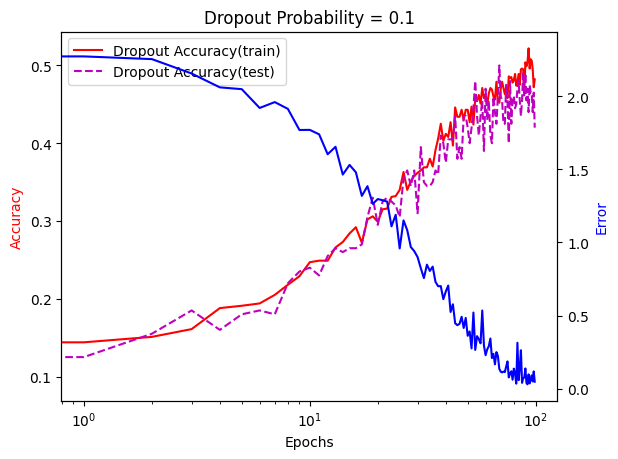

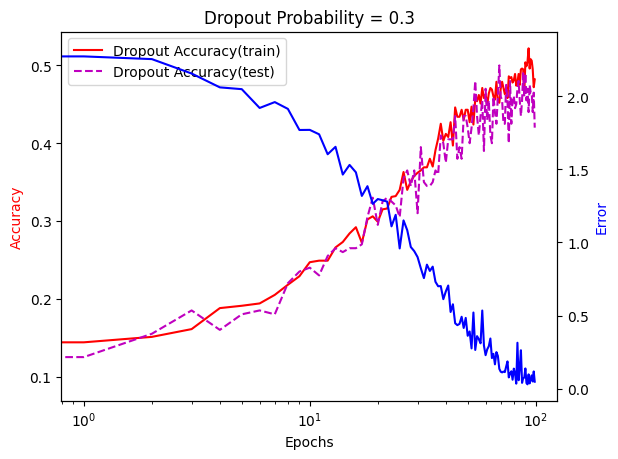

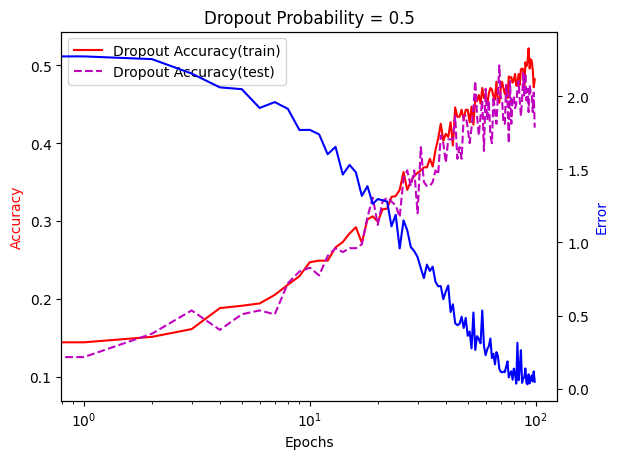

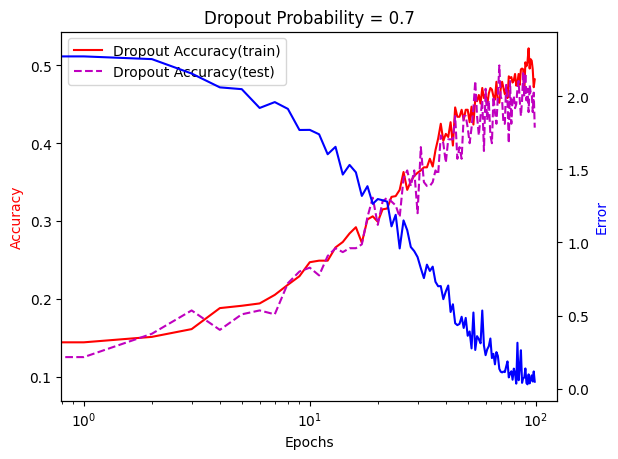

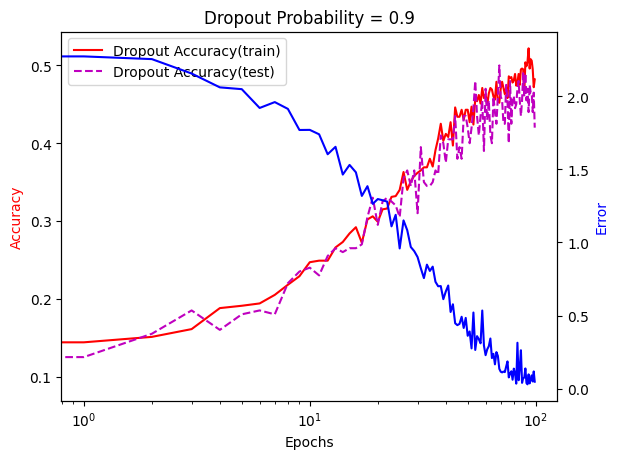

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Plot accuracy for epochs
for i in range(5):
    steps = 1
    fig, acc = plt.subplots()
    acc.semilogx(range(0, steps*len(accuracies_train[i]), steps), net1.accu_train, 'r')
    acc.semilogx(range(0, steps*len(accuracies_test[i]), steps), net1.accu_test, 'm--')
    acc.set_xlabel('Epochs')
    acc.set_ylabel('Accuracy', color = 'r')

    err = acc.twinx()
    err.semilogx(range(0, steps*len(error[i]), steps), net1.error, 'b')
    err.set_ylabel('Error', color = 'b')

    acc.legend(['Dropout Accuracy(train)', 'Dropout Accuracy(test)'])
    acc.set_title(f'Dropout Probability = {dropout_probs[i]}')
    
    plt.show()

# HW2
- MNIST dataset에서 Dropout probability의 변화에 따라 오버피팅의 양상이 어떻게 변화할지 알아봅시다.
- Due: 5/14(일) 23:59
- 제출처: eclass - 과제 (hw_02_dropout)
- .ipynb file로 업로드하여 제출
- 코드 실행 시간이 오래 걸리는 관계로, 제가 바로 확인할 수 있게끔 그래프 등이 출력된 상태로 업로드 바랍니다.